In [12]:
import argparse
import math
import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import LinfPGD, FGSM, LinfDeepFoolAttack
from advertorch.attacks import LinfSPSAAttack
from src.trainers import Trainer, FGSMTrainer
from robustbench.model_zoo.models import Carmon2019UnlabeledNet
from src.utils import adversarial_accuracy, fgsm_
from src.gradient_masking_tests import gradient_norm, fgsm_pgd_cos_dif, multi_scale_fgsm, gradient_information
import eagerpy as ep
from src.Nets import CIFAR_Wide_Res_Net, CIFAR_Res_Net, CIFAR_Net, ResNet18GradReg
%load_ext autoreload
%autoreload 2
%aimport src.Nets, src.trainers, src.gradient_masking_tests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# setup
device = torch.device("cuda")
batch_size = 128
# remove the normalize
transform = transform = transforms.Compose(
            [transforms.ToTensor()]
)
        
normalized_min = (0 - 0.5) / 0.5
normalized_max = (1 - 0.5) / 0.5
train_dataset = datasets.CIFAR10(root='data', train=True,
                                download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                  shuffle=True, num_workers=2)
test_dataset = datasets.CIFAR10(root='data', train=False,
                               download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                 shuffle=False, num_workers=2)
classes = classes = ('plane', 'car', 'bird', 'cat',
   'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# # Regular CIFAR-10  ResNet Model
model = CIFAR_Res_Net(device).eval()
model.load_state_dict(torch.load("models/cifar_res_net.model"))
step_ll_model = CIFAR_Res_Net(device).eval()
step_ll_model.load_state_dict(torch.load("models/cifar_res_net_20e_stepll.model"))
fgsm_model = CIFAR_Res_Net(device).eval()
fgsm_model.load_state_dict(torch.load("models/cifar_res_net_fgsm06.model"))
# # # CIFAR-10  ResNet Model trained with small FGSM steps
fgsm_model_small = CIFAR_Res_Net(device).eval()
fgsm_model_small.load_state_dict(torch.load("models/cifar_res_net_20e_fgsm03.model"))
gradient_norm_model = CIFAR_Res_Net(device).eval()
gradient_norm_model.load_state_dict(torch.load("models/cifar_res_net_grad_reg_20e_ld2.model"))
# # CIFAR-10  ResNet Model trained through input gradient regularization ld5
gradient_norm_model_strong = CIFAR_Res_Net(device).eval()
gradient_norm_model_strong.load_state_dict(torch.load("models/cifar_res_net_grad_reg_20e_ld5.model"))

<All keys matched successfully>

In [18]:
# smaller is better
def linearization_error(model, dataset, subset=100, batch_size=128, n_perturbations=128*10, epsilons=[0.03]):
    epsilon_errors = []
    for epsilon in epsilons:
        mean_errors = []
        for counter, data in enumerate(dataset):
            if counter > subset:
                break

            model.zero_grad()
            x = data[0].reshape((1,) + data[0].shape).to(device)
            x.requires_grad_()
            y = torch.log(model(x)[0, data[1]])
            g = torch.autograd.grad(y, x)[0]
            errors = []
            with torch.no_grad():
                for _ in range(math.ceil(n_perturbations/batch_size)):
                    perturbation = (torch.rand((batch_size, 3, 32, 32)) > 0.5).float().to(device)
                    perturbation[perturbation == 0] = -1
                    perturbation *= epsilon
#                     perturbation = torch.rand((batch_size, 3, 32, 32)).to(device)
#                     perturbation = perturbation * epsilon * 2
#                     perturbation = perturbation - epsilon
                    y_prime = torch.log(model(x.repeat(batch_size, 1, 1, 1) + perturbation)[:, data[1]])
                    approx = y.repeat(batch_size) + torch.sum(perturbation * g)
                    errors.append(torch.abs(y_prime - approx)/y_prime)
            mean_errors.append(torch.cat(errors).mean())

        epsilon_errors.append(torch.stack(mean_errors).mean())
    
    for epsilon, error in zip(epsilons, epsilon_errors):
        print("Epsilon {}: {} error".format(epsilon, error))

## Error with perturbation where each coordinate is either -eps or eps

In [17]:
linearization_error(model, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(step_ll_model, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(fgsm_model, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(fgsm_model_small, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(gradient_norm_model, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(gradient_norm_model_strong, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1])

Epsilon 0.003: 0.06999900192022324 error
Epsilon 0.03: 0.7696435451507568 error
Epsilon 0.06: 2.1171889305114746 error
Epsilon 0.1: 6.860876083374023 error
Epsilon 0.003: 0.04398001357913017 error
Epsilon 0.03: 0.36212143301963806 error
Epsilon 0.06: 0.7624298334121704 error
Epsilon 0.1: 1.3676996231079102 error
Epsilon 0.003: 0.24454203248023987 error
Epsilon 0.03: 2.3595657348632812 error
Epsilon 0.06: 5.2559075355529785 error
Epsilon 0.1: 0.7985435128211975 error
Epsilon 0.003: 0.010167415253818035 error
Epsilon 0.03: 0.1098482683300972 error
Epsilon 0.06: 0.20659400522708893 error
Epsilon 0.1: 0.4114561080932617 error
Epsilon 0.003: 0.07267075777053833 error
Epsilon 0.03: 0.8342500925064087 error
Epsilon 0.06: 2.1449363231658936 error
Epsilon 0.1: 8.656185150146484 error
Epsilon 0.003: 0.06968510150909424 error
Epsilon 0.03: 0.7737661004066467 error
Epsilon 0.06: 2.3319265842437744 error
Epsilon 0.1: 0.6373311877250671 error


(None, None, None, None, None, None)

### Error with perturbation where each coordinate is between -eps and eps

In [15]:
linearization_error(model, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(step_ll_model, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(fgsm_model, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(fgsm_model_small, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(gradient_norm_model, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(gradient_norm_model_strong, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1])

Epsilon 0.003: 0.03815454617142677 error
Epsilon 0.03: 0.4226369559764862 error
Epsilon 0.06: 0.8199584484100342 error
Epsilon 0.1: 1.7994372844696045 error
Epsilon 0.003: 0.025198251008987427 error
Epsilon 0.03: 0.24969780445098877 error
Epsilon 0.06: 0.43689537048339844 error
Epsilon 0.1: 0.7465355396270752 error
Epsilon 0.003: 0.14818336069583893 error
Epsilon 0.03: 1.387202501296997 error
Epsilon 0.06: 2.8605973720550537 error
Epsilon 0.1: 5.861645698547363 error
Epsilon 0.003: 0.005847875960171223 error
Epsilon 0.03: 0.06287860125303268 error
Epsilon 0.06: 0.11734139174222946 error
Epsilon 0.1: 0.20575229823589325 error
Epsilon 0.003: 0.042265862226486206 error
Epsilon 0.03: 0.4272255301475525 error
Epsilon 0.06: 0.9979784488677979 error
Epsilon 0.1: 2.279103994369507 error
Epsilon 0.003: 0.04246997833251953 error
Epsilon 0.03: 0.4104810655117035 error
Epsilon 0.06: 0.9477697610855103 error
Epsilon 0.1: 1.9157569408416748 error


(None, None, None, None, None, None)

## Error with perturbation where each coordinate is either -eps or eps log model

In [20]:
linearization_error(model, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(step_ll_model, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(fgsm_model, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(fgsm_model_small, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(gradient_norm_model, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1]), linearization_error(gradient_norm_model_strong, train_dataset, epsilons=[0.003, 0.03, 0.06, 0.1])

Epsilon 0.003: 0.024346143007278442 error
Epsilon 0.03: 0.24965445697307587 error
Epsilon 0.06: nan error
Epsilon 0.1: nan error
Epsilon 0.003: 0.017943227663636208 error
Epsilon 0.03: 0.17095135152339935 error
Epsilon 0.06: 0.33173343539237976 error
Epsilon 0.1: 0.5918441414833069 error
Epsilon 0.003: 0.11144037544727325 error
Epsilon 0.03: 0.9863528609275818 error
Epsilon 0.06: 2.3250176906585693 error
Epsilon 0.1: nan error
Epsilon 0.003: 0.005174829158931971 error
Epsilon 0.03: 0.05059431120753288 error
Epsilon 0.06: 0.1036352887749672 error
Epsilon 0.1: 0.18683189153671265 error
Epsilon 0.003: 0.026193438097834587 error
Epsilon 0.03: 0.27394384145736694 error
Epsilon 0.06: nan error
Epsilon 0.1: nan error
Epsilon 0.003: 0.02506929449737072 error
Epsilon 0.03: 0.2510705888271332 error
Epsilon 0.06: nan error
Epsilon 0.1: nan error


(None, None, None, None, None, None)

In [ ]:
fmodel = PyTorchModel(model, bounds=(0, 1))
attack = FGSM()
for data, target in train_loader:
    _, adv, success = attack(fmodel, data.to(device), target.to(device), epsilons=10)
    print(adv)
    break

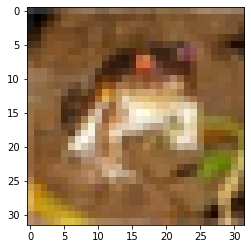

In [60]:
plt.imshow(adv[0].cpu().squeeze().permute(1, 2, 0).numpy())

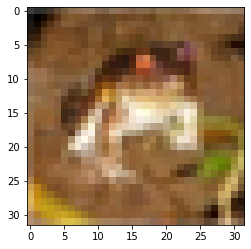

In [46]:
plt.imshow(train_dataset[0][0].cpu().permute(1, 2, 0).numpy())

In [ ]:
gradient_information(model, train_dataset, iters=50, device=device, subset_size=5000), gradient_information(fgsm_model, train_dataset, iters=50, device=device, subset_size=5000), gradient_information(fgsm_model_small, train_dataset, iters=50, device=device, subset_size=5000), gradient_information(step_ll_model, train_dataset, iters=50, device=device, subset_size=5000)